In [3]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import statsmodels.api as sm
import warnings

# Suppress scipy runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option("display.max_columns", None)

#Loading Data
ind49 = pd.read_csv("data_ind49.csv", parse_dates=["Date"], na_values=[-99.99, -999])
ind49["Date"] = ind49["Date"].dt.to_period("M")
ind49 = ind49.set_index("Date")
ind49 = ind49 / 100  # Convert from percent to decimal

print("49 Industry Returns:")
print(ind49.head())

ff3 = pd.read_csv("data_ff3.csv", parse_dates=["Date"], na_values=[-99.99, -999])
ff3["Date"] = ff3["Date"].dt.to_period("M")
ff3 = ff3.set_index("Date")
ff3 = ff3 / 100

print("Fama-French 3-Factor Data:")
print(ff3.head())

ff5 = pd.read_csv("data_ff5.csv", parse_dates=["Date"], na_values=[-99.99, -999])
ff5["Date"] = ff5["Date"].dt.to_period("M")
ff5 = ff5.set_index("Date")
ff5 = ff5 / 100

print("Fama-French 5-Factor Data:")
print(ff5.head())

mom = pd.read_csv("data_mom.csv", parse_dates=["Date"], na_values=[-99.99, -999])
mom["Date"] = mom["Date"].dt.to_period("M")
mom = mom.set_index("Date")
mom = mom / 100

print("Momentum Factor:")
print(mom.head())

49 Industry Returns:
          Agric   Food   Soda    Beer    Smoke   Toys    Fun     Books  \
Date                                                                     
1926-07  0.0237  0.0012    NaN -0.0519  0.0129  0.0865  0.0250  0.5021   
1926-08  0.0223  0.0268    NaN  0.2703  0.0650  0.1681 -0.0076  0.4298   
1926-09 -0.0057  0.0158    NaN  0.0402  0.0126  0.0833  0.0642 -0.0491   
1926-10 -0.0046 -0.0368    NaN -0.0331  0.0106 -0.0140 -0.0509  0.0537   
1926-11  0.0675  0.0626    NaN  0.0729  0.0455  0.0000  0.0182 -0.0640   

          Hshld   Clths  Hlth    MedEq   Drugs   Chems  Rubbr   Txtls   BldMt  \
Date                                                                            
1926-07 -0.0048  0.0808    NaN  0.0495  0.0091  0.0814    NaN  0.0039  0.0246   
1926-08 -0.0358 -0.0251    NaN  0.0420  0.0426  0.0550    NaN  0.0797  0.0463   
1926-09  0.0073 -0.0051    NaN  0.0402 -0.0026  0.0533    NaN  0.0230 -0.0011   
1926-10 -0.0468  0.0012    NaN  0.0347 -0.0176 -0.0476 

In [4]:
## Momentum Based Industry Selection

In [3]:
#To determine how many industries to include in the portfolio based on momentum, I tested values of N from 5 to 20. 
#For each N, I built an equal-weighted portfolio of the top N industries based on 12-month momentum and evaluated performance using Sharpe ratio and total return.

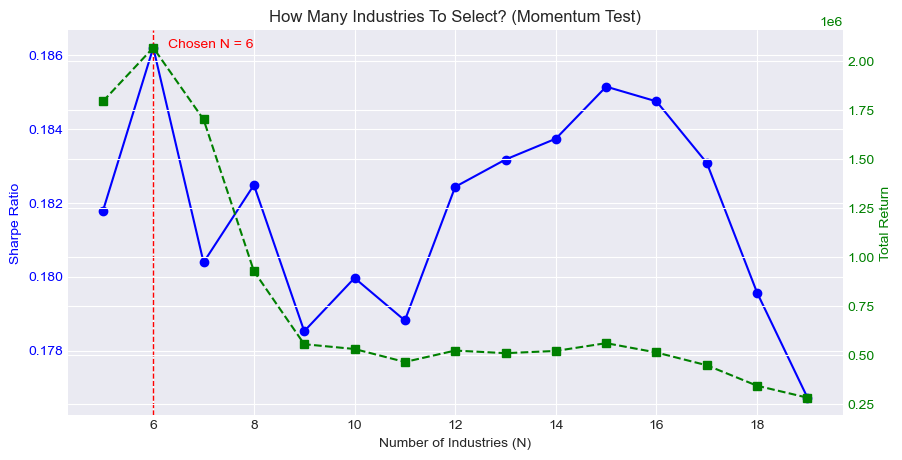

In [5]:
#Using momentum to select the number of industries
momentum_lookback = 12
start_idx = 36
test_dates = ind49.index[start_idx:]
rf_series = ff3["RF"]

#Range of N values to test
N_values = range(5, 20)
evaluation_results = []

for N in N_values:
    monthly_returns = []

    for date in test_dates:
        idx = ind49.index.get_loc(date)
        past_12m = ind49.iloc[idx - momentum_lookback:idx]
        
        #Calculating momentum
        momentum = (past_12m + 1).prod() - 1
        momentum = momentum.dropna()
        
        if len(momentum) < N:
            continue
        
        top_industries = momentum.sort_values(ascending=False).head(N).index.tolist()
        current_returns = ind49.loc[date, top_industries]
        
        #Equal-weighted return
        monthly_return = current_returns.mean()
        monthly_returns.append((date, monthly_return))

    #Return series
    if len(monthly_returns) == 0:
        continue

    dates_list, rets_list = zip(*monthly_returns)
    ret_series = pd.Series(rets_list, index=pd.PeriodIndex(dates_list, freq="M"))

    #Calculating excess return for Sharpe ratio
    rf = rf_series.loc[ret_series.index]
    excess_ret = ret_series - rf

    sharpe_ratio = excess_ret.mean() / excess_ret.std()
    total_return = (1 + ret_series).prod() - 1

    evaluation_results.append((N, sharpe_ratio, total_return))

#Creating dataframe
results_df = pd.DataFrame(evaluation_results, columns=["N", "SharpeRatio", "TotalReturn"])

#Plotting both metrics together
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Number of Industries (N)")
ax1.set_ylabel("Sharpe Ratio", color="blue")
ax1.plot(results_df["N"], results_df["SharpeRatio"], marker='o', color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Return", color="green")
ax2.plot(results_df["N"], results_df["TotalReturn"], marker='s', linestyle='--', color="green")
ax2.tick_params(axis='y', labelcolor="green")

chosen_n = 6
best_row = results_df[results_df["N"] == chosen_n]
if not best_row.empty:
    ax1.axvline(chosen_n, color='red', linestyle='--', linewidth=1)
    ax1.text(chosen_n + 0.3, best_row["SharpeRatio"].values[0], 'Chosen N = 6', color='red')

plt.title("How Many Industries To Select? (Momentum Test)")
plt.grid(True)
plt.show()

In [5]:
#After reviewing the results across different N values, I found that selecting the top 6 industries offered the highest Sharpe ratio in multiple test ranges, while maintaining a strong total return. 
#This balance between performance and risk makes N = 6 the optimal choice for this strategy going forward.

In [6]:
## Final Industry Selection Using N = 6
momentum_lookback = 12
top_n = 6
start_idx = 36  # For a 3-year buffer before starting
dates = ind49.index[start_idx:]

#Dictionary to store selected industries by month
selected_industries = {}

for date in dates:
    idx = ind49.index.get_loc(date)
    past_12m = ind49.iloc[idx - momentum_lookback:idx]
    
    # Calculating cumulative 12-month return
    momentum = (past_12m + 1).prod() - 1
    momentum = momentum.dropna()
    
    if len(momentum) < top_n:
        continue  

    top_inds = momentum.sort_values(ascending=False).head(top_n).index.tolist()
    selected_industries[date] = top_inds

#Preview of the first few months
for d in list(selected_industries.keys())[:5]:
    print(f"{d}: {selected_industries[d]}")

1929-07: ['Hardw', 'ElcEq', 'Util ', 'Chems', 'Aero ', 'Steel']
1929-08: ['ElcEq', 'Hardw', 'Util ', 'Chems', 'Aero ', 'Steel']
1929-09: ['ElcEq', 'Hardw', 'Util ', 'Chems', 'Steel', 'Mach ']
1929-10: ['Hardw', 'Util ', 'ElcEq', 'Chems', 'Telcm', 'Mach ']
1929-11: ['Hardw', 'Util ', 'ElcEq', 'Telcm', 'Chems', 'Boxes']


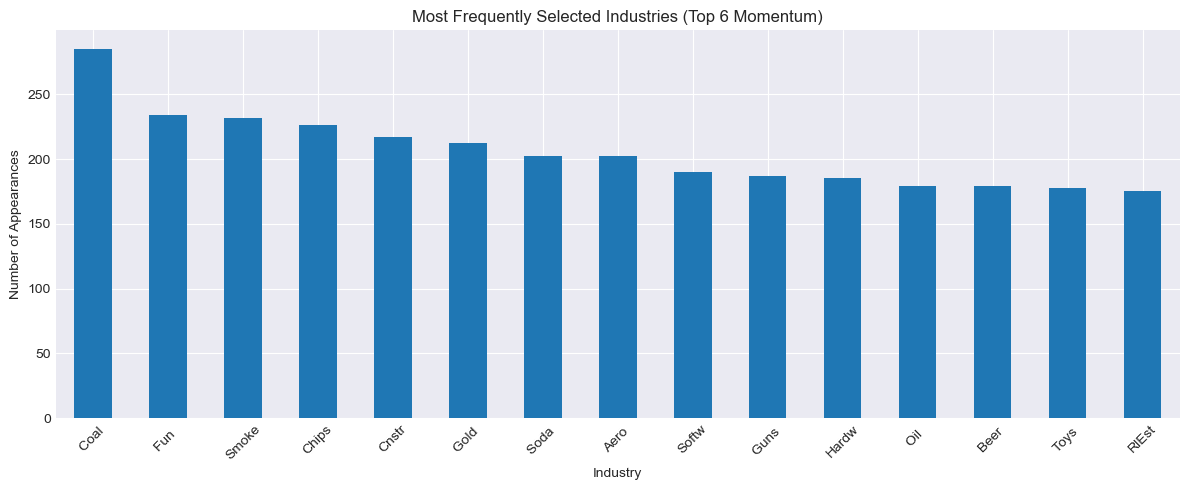

In [7]:
from collections import Counter

all_industries = [industry for month in selected_industries.values() for industry in month]
industry_counts = Counter(all_industries)

freq_df = pd.DataFrame.from_dict(industry_counts, orient="index", columns=["Frequency"])
freq_df = freq_df.sort_values("Frequency", ascending=False)

freq_df.head(15).plot(kind="bar", figsize=(12, 5), legend=False)
plt.title("Most Frequently Selected Industries (Top 6 Momentum)")
plt.ylabel("Number of Appearances")
plt.xlabel("Industry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# What i have done above:
# 1. Tested diff values of N from 1 to 49 using 12-month momentum
# 2. Evaluated performance of each N using Total Return and Sharpe Ratio, and found N = 6 as the optimal choice.
# 3. For each month in the backtest: I calculated 12-month cum return for 49 industries.
# 4. Selected top 6 industries with the highest momentum, stored them in a dictionary called selected_industries.

In [10]:
# Next Steps: 
# 1. For each month, take the top 6 industries for that month, use past 36 months of returns for that industry. 
# 2. Do calculations (mean return vector, covariance matrix, etc), run MVO.

In [43]:
# Monthly Portfolio Optimization and Return Calculation
opt_returns = []
opt_weights = []

for date in dates:
    idx = ind49.index.get_loc(date)
    selected = selected_industries.get(date, None)
    
    if not selected or len(selected) < top_n:
        continue

    # Past 12-month return data for selected industries
    past_returns = ind49[selected].iloc[idx - momentum_lookback:idx]
    
    # Expected returns and covariance
    mu = past_returns.mean().values
    cov = past_returns.cov().values
    rf = rf_series.loc[date]


    def portfolio_vol(w):
        return np.sqrt(np.dot(w.T, np.dot(cov, w)))

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1.0)] * top_n

    # Initial guess
    w0 = np.array([1 / top_n] * top_n)

    result = minimize(portfolio_vol, w0, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        weights = result.x
        current_ret = np.dot(ind49.loc[date, selected], weights)
        opt_returns.append((date, current_ret))
        opt_weights.append((date, dict(zip(selected, weights))))

# Convert to DataFrame
opt_dates, opt_rets = zip(*opt_returns)
opt_ret_series = pd.Series(opt_rets, index=pd.PeriodIndex(opt_dates, freq="M"))

# Example of viewing the first 5 months of weights
for d, w in opt_weights[:5]:
    print(f"{d}: {w}")


1929-07: {'Hardw': np.float64(0.7087201690458015), 'ElcEq': np.float64(0.0), 'Util ': np.float64(9.974659986866641e-18), 'Chems': np.float64(0.04616204479454506), 'Aero ': np.float64(0.0), 'Steel': np.float64(0.24511778615965368)}
1929-08: {'ElcEq': np.float64(5.38230399056247e-17), 'Hardw': np.float64(0.7058635582731465), 'Util ': np.float64(0.008370522850227508), 'Chems': np.float64(0.043060938509227514), 'Aero ': np.float64(7.118899180756192e-17), 'Steel': np.float64(0.24270498036739832)}
1929-09: {'ElcEq': np.float64(1.599062482635165e-17), 'Hardw': np.float64(0.7184228691337066), 'Util ': np.float64(0.026456716859358805), 'Chems': np.float64(0.024123266483227893), 'Steel': np.float64(0.23099714752370673), 'Mach ': np.float64(2.4076493620863954e-17)}
1929-10: {'Hardw': np.float64(0.6033311898260889), 'Util ': np.float64(0.0), 'ElcEq': np.float64(0.023073832688108576), 'Chems': np.float64(1.1058862159352145e-17), 'Telcm': np.float64(0.37359497748580267), 'Mach ': np.float64(1.246832

In [35]:
# Monthly Portfolio Optimization and Return Calculation
opt_returns = []
opt_weights = []

for date in dates:
    idx = ind49.index.get_loc(date)
    selected = selected_industries.get(date, None)
    
    if not selected or len(selected) < top_n:
        continue

    # Past 12-month return data for selected industries
    past_returns = ind49[selected].iloc[idx - momentum_lookback:idx]
    
    # Expected returns and covariance
    mu = past_returns.mean().values
    cov = past_returns.cov().values
    rf = rf_series.loc[date]


    def neg_sharpe(w):
        port_return = np.dot(w, mu)
        port_std = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -((port_return - rf) / port_std)

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1.0)] * top_n

    # Initial guess
    w0 = np.array([1 / top_n] * top_n)

    result = minimize(neg_sharpe, w0, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        weights = result.x
        current_ret = np.dot(ind49.loc[date, selected], weights)
        opt_returns.append((date, current_ret))
        opt_weights.append((date, dict(zip(selected, weights))))

# Convert to DataFrame
opt_dates, opt_rets = zip(*opt_returns)
opt_ret_series = pd.Series(opt_rets, index=pd.PeriodIndex(opt_dates, freq="M"))

# Example of viewing the first 5 months of weights
for d, w in opt_weights[:5]:
    print(f"{d}: {w}")


1929-07: {'Hardw': np.float64(0.8503828500965384), 'ElcEq': np.float64(0.0), 'Util ': np.float64(1.5938455791485616e-15), 'Chems': np.float64(0.1180545503343397), 'Aero ': np.float64(4.485087512515656e-15), 'Steel': np.float64(0.03156259956912059)}
1929-08: {'ElcEq': np.float64(0.1275550411982048), 'Hardw': np.float64(0.7945019361132624), 'Util ': np.float64(1.7260667992558681e-16), 'Chems': np.float64(0.07794302268853265), 'Aero ': np.float64(0.0), 'Steel': np.float64(1.1440501324067043e-15)}
1929-09: {'ElcEq': np.float64(0.09481165924079128), 'Hardw': np.float64(0.8087168541932721), 'Util ': np.float64(7.255183843302053e-18), 'Chems': np.float64(0.09647148656593692), 'Steel': np.float64(2.7142112003579986e-17), 'Mach ': np.float64(0.0)}
1929-10: {'Hardw': np.float64(0.7311317986577902), 'Util ': np.float64(0.0), 'ElcEq': np.float64(0.16081163976811805), 'Chems': np.float64(0.0), 'Telcm': np.float64(0.10805656157409164), 'Mach ': np.float64(1.7691468949532219e-16)}
1929-11: {'Hardw': 

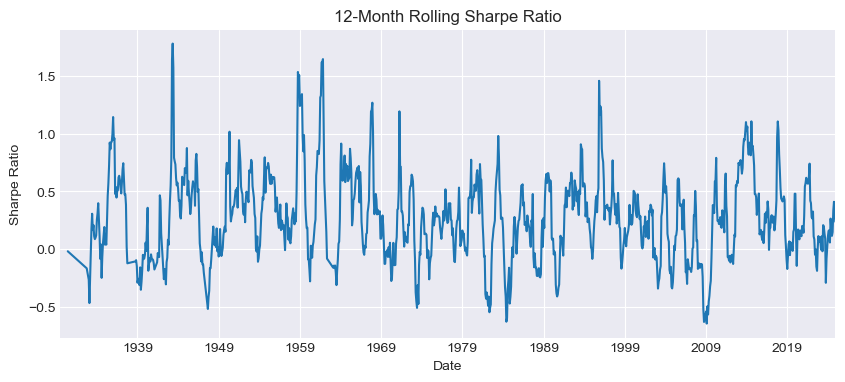

In [44]:
# Calculate excess returns (portfolio - risk-free rate)
rf = ff3["RF"].reindex(opt_ret_series.index)
excess_returns = opt_ret_series - rf

# 12-month rolling Sharpe ratio
rolling_sharpe = excess_returns.rolling(12).mean() / excess_returns.rolling(12).std()

# Plot
rolling_sharpe.plot(figsize=(10, 4), title="12-Month Rolling Sharpe Ratio")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.grid(True)
plt.show()

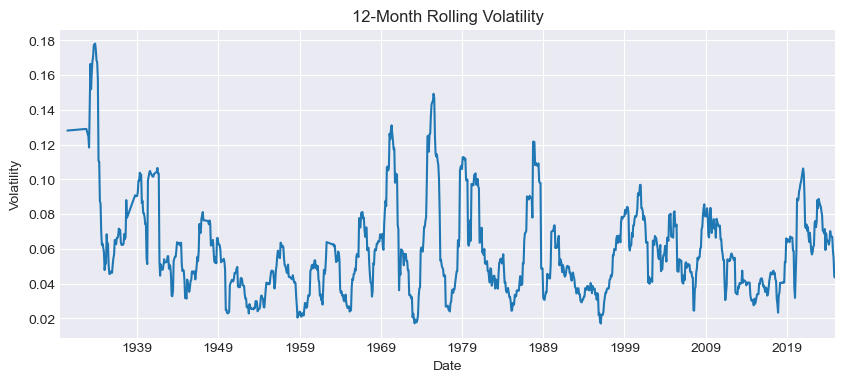

In [29]:
# 12-month rolling volatility
rolling_vol = opt_ret_series.rolling(12).std()

# Plot
rolling_vol.plot(figsize=(10, 4), title="12-Month Rolling Volatility")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [ ]:
# Replace XX with your group number
group_id = "13"
output_df = pd.DataFrame({
    "Date": opt_ret_series.index.to_timestamp().strftime("%Y-%m"),
    f"Group_{group_id}": opt_ret_series.values
})

output_df.to_csv(f"Group_{group_id}.csv", index=False)
print("✅ Portfolio returns exported successfully to Group_13.csv")
print(output_df.head()

In [46]:
# Align risk-free rate
rf = ff3["RF"].reindex(opt_ret_series.index)

# Excess returns
excess_returns = opt_ret_series - rf

# Total Sharpe Ratio
total_sharpe = excess_returns.mean() / excess_returns.std()
print(f"Total Sharpe Ratio: {total_sharpe:.4f}")

Total Sharpe Ratio: 0.1990


In [16]:
excess_returns.rolling(60).mean() / excess_returns.rolling(60).std()


1929-07         NaN
1929-08         NaN
1929-09         NaN
1929-10         NaN
1929-11         NaN
             ...   
2024-08    0.213187
2024-09    0.217508
2024-10    0.215096
2024-11    0.223037
2024-12    0.216060
Freq: M, Length: 1085, dtype: float64

In [47]:
# Equal-weighted momentum portfolio returns
equal_mom_returns = []

for date in dates:
    top_inds = selected_industries.get(date, None)
    if not top_inds or len(top_inds) < top_n:
        continue

    returns = ind49.loc[date, top_inds]
    equal_return = returns.mean()  # Equal weights
    equal_mom_returns.append((date, equal_return))

# Convert to Series
mom_dates, mom_rets = zip(*equal_mom_returns)
equal_mom_series = pd.Series(mom_rets, index=pd.PeriodIndex(mom_dates, freq="M"))


In [48]:
rf = ff3["RF"].reindex(equal_mom_series.index)
equal_excess = equal_mom_series - rf

# Equal-weighted momentum Sharpe
equal_sharpe = equal_excess.mean() / equal_excess.std()
print(f"Equal-Weighted Momentum Sharpe Ratio: {equal_sharpe:.4f}")

Equal-Weighted Momentum Sharpe Ratio: 0.1862
